### Import packages 

In [19]:
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import os

import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import numpy as np
import random
from PIL import Image
from IPython.display import Image

### Make sure you are running the current up-to-date version of Keras

In [2]:
import keras
keras.__version__

'2.2.4'

In [3]:
train_data_dir = 'asl/asl_alphabet_train'
epochs = 4
batch_size = 64
n_classes = 29
val_per= 0.1
target_size = (64,64)
target_dims = (64,64,3)

In [4]:
print(os.path.isdir(train_data_dir))
print(os.listdir(train_data_dir))
classes = os.listdir(train_data_dir)

True
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
len(classes)

29

### Let's view some data

In [6]:
def plot_samples(letter,sample_number):
    print("{} Samples images for letter {} ".format(sample_number,letter))
    base_path = 'asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    plt.figure(figsize=(24,24))
    for i in range(sample_number):
        imgs = random.sample(path_contents, sample_number)
        plt.subplot(131+i)
        plt.imshow(cv2.imread(imgs[i]))
    return



3 Samples images for letter X 


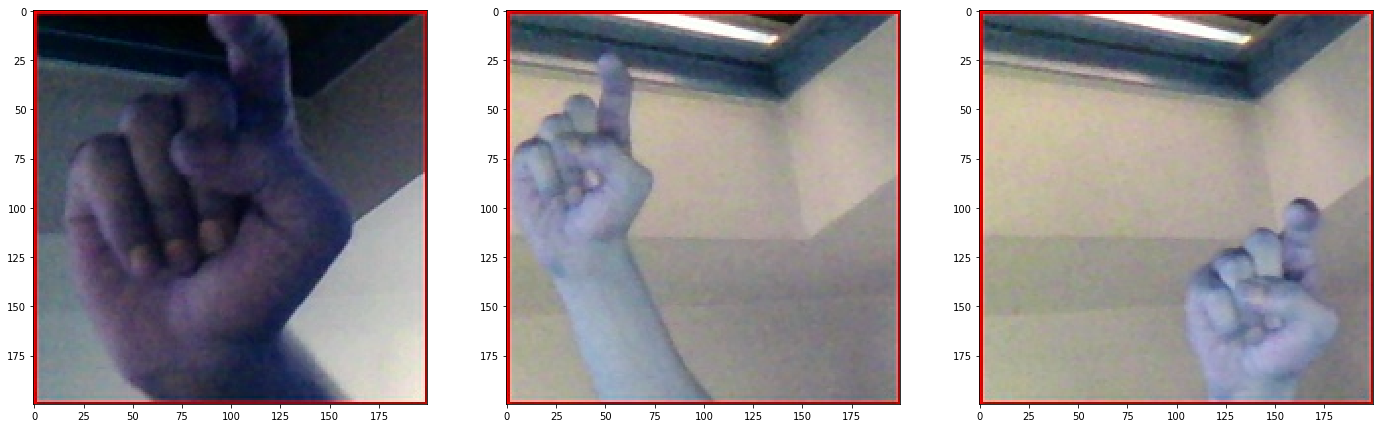

In [7]:
plot_samples('X',3)

2 Samples images for letter G 


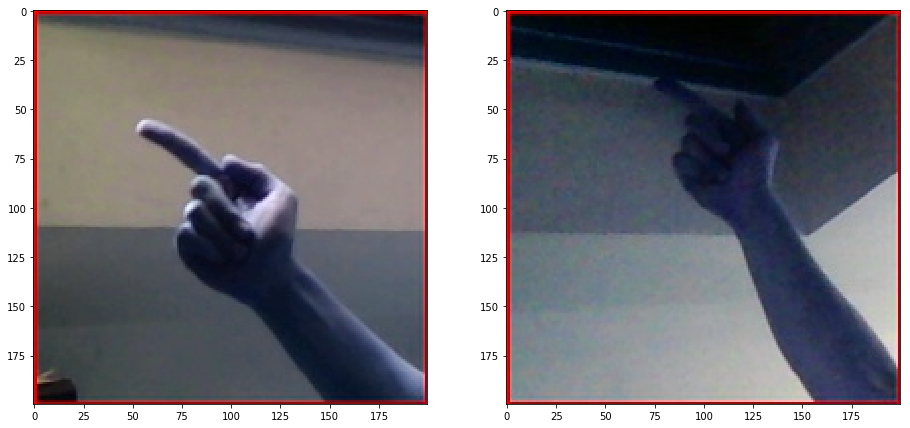

In [8]:
plot_samples('G',2)

### My last prototype did not take full advantage of the train/validation split offerings with the updated Keras framework, 

### therefore with a manual work around the last model did not achieve a good validation score, however this time round we will try a smoother approach to train/test split

In [10]:
data_feed = image.ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True,
                                    validation_split=val_per)

In [11]:
training = data_feed.flow_from_directory(train_data_dir, 
                                              target_size = target_size, 
                                              batch_size = batch_size, 
                                              shuffle=True,
                                            subset="training")

validation = data_feed.flow_from_directory(train_data_dir, 
                                              target_size = target_size, 
                                              batch_size = batch_size,
                                              subset="validation")


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


### Will reuse same framework from last prototype - stacked CNN with 50% dropout.

In [13]:
model = Sequential()
model.add(Conv2D(64,kernel_size=4,strides=1, input_shape=target_dims))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=4,strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=4,strides=1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=4,strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

### Since we have multi-classes 29 to be exact I will use a catergorical crossentopy loss function

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
               metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 61, 64)        3136      
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       131200    
__________

In [17]:
print(training.class_indices)
class_indicies = training.class_indices

{'I': 8, 'W': 22, 'O': 14, 'K': 10, 'G': 6, 'U': 20, 'D': 3, 'A': 0, 'Y': 24, 'H': 7, 'nothing': 27, 'M': 12, 'J': 9, 'X': 23, 'N': 13, 'V': 21, 'R': 17, 'del': 26, 'space': 28, 'T': 19, 'B': 1, 'Z': 25, 'L': 11, 'E': 4, 'S': 18, 'F': 5, 'P': 15, 'Q': 16, 'C': 2}


In [18]:
model.fit_generator(training, epochs = epochs, validation_data = validation)

Epoch 1/4
1224/1224 [==============================] - 136s 111ms/step - loss: 1.1007 - acc: 0.6593 - val_loss: 0.6931 - val_acc: 0.8005
Epoch 2/4
1224/1224 [==============================] - 140s 114ms/step - loss: 0.1685 - acc: 0.9448 - val_loss: 0.7650 - val_acc: 0.7987
Epoch 3/4
1224/1224 [==============================] - 140s 114ms/step - loss: 0.1053 - acc: 0.9664 - val_loss: 0.5441 - val_acc: 0.8675
Epoch 4/4
1224/1224 [==============================] - 140s 115ms/step - loss: 0.0815 - acc: 0.9748 - val_loss: 0.6444 - val_acc: 0.8651


### Already this model has outperformed the last prototype, which shows that data preprocessing and achieving balance of representation in your train/test split can make or break a model! 

### So let's test some data!

In [24]:
def prediction(image_directory):
    img = image.load_img(image_directory, target_size=(64,64))
    image_rescale = image.img_to_array(img)
    image_rescale = np.expand_dims(image_rescale,axis=0)
    image_test = np.vstack([image_rescale])
    prediction = model.predict_classes(image_test)
    if prediction in class_indicies.values():
        for key, value in class_indicies.items():
            if value == prediction:
                print("I predict this is a {}".format(key))

In [25]:
test_image_w= 'asl_alphabet_test/W_test.jpg'

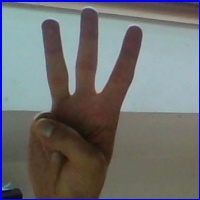

In [26]:
Image(filename=test_image_w)

In [27]:
prediction(test_image_w)

I predict this is a W


In [28]:
test_image_f= 'asl_alphabet_test/F_test.jpg'

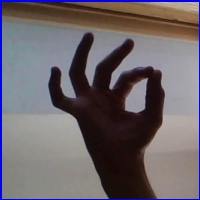

In [29]:
Image(filename=test_image_f)

In [30]:
prediction(test_image_f)

I predict this is a F


In [31]:
test_image_L= 'asl_alphabet_test/L_test.jpg'

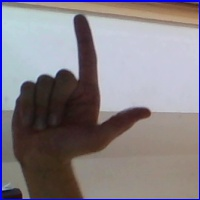

In [32]:
Image(filename=test_image_L)

In [33]:
prediction(test_image_L)

I predict this is a L


In [34]:
test_image_X= 'asl_alphabet_test/X_test.jpg'

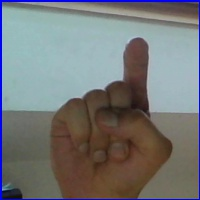

In [35]:
Image(filename=test_image_X)

In [36]:
prediction(test_image_X)

I predict this is a X


### Perfect!!! The model has improved with this second iteration and added improvements!

### Next step is to have the model define sign language within a video recording!